In [1]:
import os
import sys
sys.path.insert(0, '/tf')
import importlib

gpu_num = "0" # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
import sionna
importlib.reload(sionna)

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

In [2]:
import numpy as np
import torch
import json
import os
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sionna.rt import load_scene, Transmitter, Receiver

def voxelize_scene(scene, resolution=32):
    """Voxelize scene using Mitsuba's mesh data with material properties"""
    size = np.array(scene.size)
    center = np.array(scene.center)
    min_bound = center - size/2
    max_bound = center + size/2
    voxel_size = size / resolution

    # Initialize voxel grid [X,Y,Z, features]
    # Features: [occupied, permittivity, conductivity, roughness]
    voxels = np.zeros((resolution, resolution, resolution, 5))
    
    # Create object name to material mapping
    obj_materials = {obj.name: obj.radio_material for obj in scene.objects.values()}

    for shape in tqdm(scene.mi_scene.shapes(), desc="Voxelizing"):

            
        # Get object name from shape name (remove .ply extension)
        child_id = shape.id()
        obj_name = child_id.replace('mesh-', '', 1)
        mat = obj_materials.get(obj_name)
        if not mat:
            continue
        bbox = shape.bbox()
        # Get mesh bounding box
        bbox_min = np.array([bbox.min.x, bbox.min.y, bbox.min.z])
        bbox_max = np.array([bbox.max.x, bbox.max.y, bbox.max.z])
        
        # Convert to voxel coordinates
        vox_min = ((bbox_min - min_bound) / voxel_size).astype(int)
        vox_max = ((bbox_max - min_bound) / voxel_size).astype(int) + 1
        
        # Clip to grid dimensions
        vox_min = np.clip(vox_min, 0, resolution)
        vox_max = np.clip(vox_max, 0, resolution)

        # Mark occupied voxels with material properties
        voxels[vox_min[0]:vox_max[0],
               vox_min[1]:vox_max[1],
               vox_min[2]:vox_max[2]] = [
                   1.0,
                   mat.relative_permittivity,
                   mat.conductivity,
                   mat.scattering_coefficient,
                   mat.xpd_coefficient
               ]

    return voxels

In [3]:
# 1. Data Collection ======================================================
def collect_data(scene_path, output_dir, num_samples=100, max_depth=2, max_paths=110,resolution=100):

    os.makedirs(output_dir, exist_ok=True)

    scene = load_scene(scene_path)

    Walls= ['mesh-wall_ym','mesh-wall_yp','mesh-floor_001','mesh-wall_xm','mesh-wall_xp'] #'mesh-floor'
    Woods = ['Bed_frame','Bookshelf-itu_wood','Bookshelf-itu_wood-001','Chair-itu_wood','Chair-itu_wood-001','Coffe_table','Sofa-itu_wood','Sofa-itu_wood-001','Sofa-itu_wood-002','Table-itu_wood','Table-itu_wood-001']
    Metals= ['Circle','Circle_001','Coat_Rack','Cylinder','Cylinder_001','LetterA','LetterB',
    'LetterC','LetterD','LetterE','LetterF','LetterG','LetterH','LetterI','LetterJ','LetterK',
    'LetterL','LetterM','LetterN','LetterO','LetterP','LetterQ','LetterR','LetterS','LetterT',
    'LetterU','LetterV','LetterW','LetterX','LetterY','LetterZ','Spoon','Plane','Plane_001','Sweep_floor_lamp-itu_metal','Sweep_floor_lamp-itu_metal-001']
    Glass = ['Saucer-itu_glass','Saucer-itu_glass-001','Saucer-itu_glass-002','Teacup-itu_glass','Teacup-itu_glass-001']

    XPD_coefficient = 0.0377
    S = 0.2
    for w in Walls:
        scene.get(w).radio_material.xpd_coefficient = tf.Variable(XPD_coefficient, dtype=tf.float32)
        scene.get(w).radio_material.scattering_coefficient = tf.Variable(S, dtype=tf.float32)



    for w in Woods:
        scene.get(w).radio_material.xpd_coefficient = tf.Variable(XPD_coefficient, dtype=tf.float32)
        scene.get(w).radio_material.scattering_coefficient = tf.Variable(S, dtype=tf.float32)


    for w in Glass:
        scene.get(w).radio_material.xpd_coefficient = tf.Variable(XPD_coefficient, dtype=tf.float32)
        scene.get(w).radio_material.scattering_coefficient = tf.Variable(S, dtype=tf.float32)

    for w in Metals:
        scene.get(w).radio_material.xpd_coefficient = tf.Variable(0.0, dtype=tf.float32)
        scene.get(w).radio_material.scattering_coefficient = tf.Variable(1, dtype=tf.float32)

    # Voxelize scene once
    scene_voxels = voxelize_scene(scene,resolution)
    np.save(os.path.join(output_dir, "scene_voxels.npy"), scene_voxels)
    
    S0 = scene.size[0] - 0.5
    S1 = scene.size[1] - 0.5
    S2 = scene.size[2] - 0.5

    Center = scene.center

    # Initialize dataset container
    dataset = []
        
    for sample_idx in range(num_samples):
        # Generate random Tx/Rx positions
        scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

        # Configure antenna array for all receivers
        scene.rx_array = PlanarArray(num_rows=1,
                                    num_cols=1,
                                    vertical_spacing=0.5,
                                    horizontal_spacing=0.5,
                                    pattern="dipole",
                                    polarization="V")

        tx_pos = np.random.uniform(low=[-S0/2,-S1/2,-S2/2], high=[S0/2,S1/2,S2/2], size=3)
        tx_pos = np.array(Center + tx_pos)
        rx_pos = np.random.uniform(low=[-S0/2,-S1/2,-S2/2], high=[S0/2,S1/2,S2/2], size=3)
        rx_pos = np.array(Center + rx_pos)

        # Add devices to scene
        tx = Transmitter(name=f"tx_{sample_idx}", position=tx_pos)
        rx = Receiver(name=f"rx_{sample_idx}", position=rx_pos)
        scene.add(tx)
        scene.add(rx)
        
        # Compute paths
        paths = scene.compute_paths(
            max_depth=max_depth,
            num_samples=int(10e6),
            los=True,
            reflection=True,
            scattering=True
        )
        
        # Get CIR parameters
        a, tau = paths.cir(los=True,reflection=True, scattering=True)
        
        # Convert to numpy arrays and separate complex numbers
        a_real = np.real(a.numpy())
        a_imag = np.imag(a.numpy())
        tau_np = tau.numpy()

        # Pad/truncate to max_paths
        def process_array(arr, target_shape,dim):
            if arr.shape[dim] > max_paths:
                return arr[..., :max_paths, :]
            pad_shape = list(arr.shape)
            pad_shape[dim] = max_paths - arr.shape[dim]
            return np.concatenate([arr, np.zeros(pad_shape)], axis=dim)

        def process_tau_array(arr, target_shape,dim):
            if arr.shape[dim] > max_paths:
                return arr[..., :, :max_paths]
            pad_shape = list(arr.shape)
            pad_shape[dim] = max_paths - arr.shape[dim]
            return np.concatenate([arr, np.zeros(pad_shape)], axis=dim)       
        
        a_real_processed = process_array(a_real, (1, 1, 1, 1, max_paths, 1),-2)
        a_imag_processed = process_array(a_imag, (1, 1, 1, 1, max_paths, 1),-2)
        tau_processed = process_tau_array(tau_np, (1, 1, 1, max_paths),-1)

        # Store sample
        dataset.append({
            "tx_pos": tx_pos.tolist(),
            "rx_pos": rx_pos.tolist(),
            "a_real": a_real_processed.tolist(),
            "a_imag": a_imag_processed.tolist(),
            "tau": tau_processed.tolist()      
              })
        
        # Clean up
        scene.remove(tx.name)
        scene.remove(rx.name)
        
        # Save periodically
        if sample_idx % 10 == 0:
            with open(os.path.join(output_dir, "dataset.json"), "w") as f:
                json.dump(dataset, f)
    
    # Final save
    with open(os.path.join(output_dir, "dataset.json"), "w") as f:
        json.dump(dataset, f)


In [4]:
import json, math
import numpy as np
import torch
from torch.utils.data import Dataset

class CIRDataset(Dataset):
    def __init__(self,
                 data_path,
                 voxels_path,
                 max_paths=15,
                 L=4,
                 eps=1e-8):
        # 1) load CIR samples
        with open(data_path, "r") as f:
            self.data = json.load(f)
        self.max_paths = max_paths
        self.eps = eps
        self.L = L

        # 2) load voxels: shape (D, H, W, F)
        vox_np = np.load(voxels_path)  
        assert vox_np.ndim == 4, "expected shape (D,H,W,F)"
        D, H, W, F = vox_np.shape
        N = D*H*W

        # flatten to (N, F)
        vox_flat = torch.from_numpy(vox_np.reshape(-1, F)).float()  # (N,F)

        # 3) build normalized coords in [0,1]^3 for each of the N voxels
        idx = np.indices((D,H,W)).reshape(3, -1).T  # (N,3) in [0..D-1,H-1,W-1]
        idx = idx / np.array([D-1, H-1, W-1])[None] # normalize
        coords = torch.from_numpy(idx).float()       # (N,3)

        # 4) build Fourier‐features for each coord → (N, 6L)
        freqs = (2.0**torch.arange(L).float()) * math.pi  # (L,)
        pe_list = []
        for f_ in freqs:
            pe_list.append(torch.sin(coords * f_))  # (N,3)
            pe_list.append(torch.cos(coords * f_))  # (N,3)
        pe = torch.cat(pe_list, dim=1)             # (N, 6L)

        # 5) summarize: (F,6L) = vox_flatᵀ @ pe
        summary_mat = vox_flat.T @ pe              # (F, 6L)

        # 6) flatten to (F*6L,)
        self.scene_summary = summary_mat.reshape(-1)  # torch.Tensor (F*6L,)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smp = self.data[idx]
        # tx/rx
        tx = torch.tensor(smp["tx_pos"], dtype=torch.float32)
        rx = torch.tensor(smp["rx_pos"], dtype=torch.float32)
        pos = torch.cat([tx, rx], dim=0)  # (6,)

        # complex taps
        a_real = torch.tensor(smp["a_real"], dtype=torch.float32).view(-1)
        a_imag = torch.tensor(smp["a_imag"], dtype=torch.float32).view(-1)
        a_cplx = a_real + 1j*a_imag

        # log‐amp & phase
        amp   = torch.log(torch.abs(a_cplx) + self.eps)
        phase = torch.angle(a_cplx)

        # log‐delay
        tau    = torch.tensor(smp["tau"], dtype=torch.float32).view(-1)
        logtau = torch.log(tau + self.eps)

        return {
          "positions":      pos,              # (6,)
          "scene_summary": self.scene_summary, # (F*6L,)
          "log_amp":        amp,               # (max_paths,)
          "phase":          phase,             # (max_paths,)
          "log_delay":      logtau,             # (max_paths,)
          "a_real": a_real,
          "a_imag": a_imag

        }

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AmpPredictor(nn.Module):
    def __init__(self,
                 input_dim,      # 6 + scene_summary_dim
                 max_paths=100,
                 L=4):
        super().__init__()
        self.max_paths = max_paths
        self.L         = L

        self.pos_encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.GELU(),
            nn.Linear(512, 1024),
            nn.ReLU()
        )


        self.attention = nn.MultiheadAttention(embed_dim=1024, num_heads=512)

        # log-amplitude head
        self.amp_head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, max_paths)
        )


    def forward(self, positions, scene_summary):
        x = torch.cat([positions, scene_summary], dim=1)  # (B, input_dim)
        x = self.pos_encoder(x)                          # (B, 256)
        x = x.unsqueeze(0)                               # (1, B, 256)
        attn_out, _ = self.attention(x, x, x)
        x = attn_out.squeeze(0)                          # (B, 256)
        amp_pred   = self.amp_head(x)    # (B, max_paths)

        return amp_pred

#-------------------------------------------------------------------

class  PhasePredictor(nn.Module):
    def __init__(self,
                 input_dim,      # 6 + scene_summary_dim
                 max_paths=100,
                 L=4):
        super().__init__()
        self.max_paths = max_paths
        self.L         = L

        # 1) common encoder
        self.pos_encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Linear(512, 1024),
            nn.ReLU()
        )

        # 2) self-attention over the single token
        self.attention = nn.MultiheadAttention(embed_dim=1024, num_heads=512)
        # phase head
        self.phase_head = nn.Sequential(
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(256, max_paths)
            # nn.Tanh() 
        )

    def forward(self, positions, scene_summary):
        # 1) concat & encode
        x = torch.cat([positions, scene_summary], dim=1)  # (B, input_dim)
        x = self.pos_encoder(x)                          # (B, 256)
        x = x.unsqueeze(0)                               # (1, B, 256)
        attn_out, _ = self.attention(x, x, x)
        x = attn_out.squeeze(0)                          # (B, 256)
        phase_pred = self.phase_head(x)  # (B, max_paths)


        return phase_pred
#---------------------------------------------------------------------
class TauPredictor(nn.Module):
    def __init__(self,
                 input_dim,      # 6 + scene_summary_dim
                 max_paths=100,
                 L=4):
        super().__init__()
        self.max_paths = max_paths
        self.L         = L

        # 1) common encoder
        self.pos_encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Linear(512, 1024),
            nn.ReLU()
        )

        # 2) self-attention over the single token
        self.attention = nn.MultiheadAttention(embed_dim=1024, num_heads=512)

        self.tau_head = nn.Sequential(
            nn.Linear(1024, 128),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(128, max_paths)
        )

    def forward(self, positions, scene_summary):
        # 1) concat & encode
        x = torch.cat([positions, scene_summary], dim=1)  # (B, input_dim)
        x = self.pos_encoder(x)                          # (B, 256)
        x = x.unsqueeze(0)                               # (1, B, 256)
        attn_out, _ = self.attention(x, x, x)
        x = attn_out.squeeze(0)                          # (B, 256)
        tau_pred   = self.tau_head(x)    # (B, max_paths)

        return tau_pred

In [43]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# from torch.optim.lr_scheduler import StepLR
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# import math


# def train(resume_from = None,
#           data_path_=None,
#           voxels_path=None,
#           num_epochs=100,
#           batch_size=5,
#           lr=1e-3/2,
#           max_paths=100,
#           L=4,
#           device=None):

#     device = device or ("cuda" if torch.cuda.is_available() else "cpu")

#     # 1) Dataset & Loader
#     dataset = CIRDataset(data_path_,
#                          voxels_path,
#                          max_paths=max_paths,
#                          L=L)
#     loader  = DataLoader(dataset,
#                          batch_size=batch_size,
#                          shuffle=True,
#                          num_workers=4,
#                          pin_memory=True)

#     # 2) Compute input_dim = 6 positions + scene_summary length
#     scene_summary_dim = dataset.scene_summary.numel()
#     input_dim = 6 + scene_summary_dim
#     print("MLP input dim:", input_dim)

#     # 3) Instantiate model (positional args)
#     amp_model = AmpPredictor(input_dim, max_paths, L).to(device)
#     optimizer_amp = torch.optim.Adam(model.parameters(), lr=lr)
#     # plateau_sched = ReduceLROnPlateau(optimizer, patience=45, factor=0.95)
#     step_sched_amp   = StepLR(optimizer, step_size=10, gamma=0.9)

#     phase_model = PhasePredictor(input_dim, max_paths, L).to(device)
#     optimizer_phase = torch.optim.Adam(model.parameters(), lr=lr)
#     step_sched_phase   = StepLR(optimizer, step_size=10, gamma=0.9)

#     tau_model = TauPredictor(input_dim, max_paths, L).to(device)
#     optimizer_tau = torch.optim.Adam(model.parameters(), lr=lr)
#     step_sched_tau   = StepLR(optimizer, step_size=10, gamma=0.9)

#     mse = nn.MSELoss()

#     # 4) Training loop
#     for epoch in range(1, num_epochs+1):
#         model.train()
#         running_loss = 0.0

#         for batch in loader:
#             pos     = batch["positions"].to(device)      # (B,6)
#             summary = batch["scene_summary"].to(device)  # (B,scene_summary_dim)
#             log_amp = batch["log_amp"].to(device)        # (B,max_paths)

#             phase   = batch["phase"].to(device)          # (B,max_paths)
#             phase_norm = phase / math.pi

#             log_tau = batch["log_delay"].to(device)      # (B,max_paths)

#             optimizer.zero_grad()

#             amp_pred = amp_model(pos, summary) 
#             phase_pred = phase_model(pos, summary) 
#             tau_pred = tau_model(pos, summary) 

#             loss_amp   = mse(amp_pred,   log_amp)    # log-amp GT
#             loss_phase = mse(phase_pred, phase_norm)      # phase GT
#             loss_tau   = mse(tau_pred,   log_tau)    # log-delay GT

#             loss = loss_amp + 10*loss_phase + loss_tau
            
#             if loss == None:
#                 continue
#             loss.backward()
#             optimizer.step()


#             running_loss += loss.item() * pos.size(0)

#         epoch_loss = running_loss / len(dataset)

#         print(f"Epoch {epoch}/{num_epochs}  Loss: {epoch_loss:.6f}")

#         # plateau_sched.step(epoch_loss)  # drops on plateau
#         step_sched.step()               # drops every 100 epochs

#         current_lr = optimizer.param_groups[0]['lr']
#         if epoch % 10 == 0 or epoch==1:
#             print(f"  ---> new learning rate: {current_lr:.2e}")
            
#         if epoch % 50 == 0:
#             torch.save(model.state_dict(), f"channelpred_ep{epoch}.pt")

#     print("Training done.")
#     return model, loader

In [44]:
OUTPUT_DIR = "./channel_scatter_room"
DATA_PATH = os.path.join(OUTPUT_DIR, "dataset.json")

if __name__ == "__main__":
#     # Data collection parameters
    SCENE_PATH = "small hallway with stuff w:o roof/room.xml"
    NUM_SAMPLES = 300
    
#     # Collect data
    # collect_data(scene_path=SCENE_PATH, output_dir=OUTPUT_DIR, num_samples= NUM_SAMPLES)
#     model, loader = train(resume_from="channelpred_ep1000.pt", data_path_ = DATA_PATH ,voxels_path="/root/channel_data/scene_voxels.npy")

In [47]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

def train(resume_from=None,
          data_path_=None,
          voxels_path=None,
          num_epochs=100,
          batch_size=5,
          lr=1e-3,
          max_paths=100,
          L=4,
          test_split=0.2,
          seed=42,
          device=None):

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # 1) load full dataset and split
    full_ds = CIRDataset(data_path_, voxels_path, max_paths=max_paths, L=L)
    N = len(full_ds)
    n_test  = int(N*test_split)
    n_train = N - n_test
    torch.manual_seed(seed)
    train_ds, test_ds = random_split(full_ds, [n_train, n_test])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4)
    print(f"Dataset stats → total: {N}, train: {n_train}, test: {n_test}")


    # ----------------------  pick one deterministic example  ----------------------   NEW
    single_idx   = 0                                 # <- which sample to plot
    single       = full_ds[single_idx]
    x_pos        = single["positions"     ].unsqueeze(0).to(device)     # (1, …)
    x_summary    = single["scene_summary" ].unsqueeze(0).to(device)
    y_amp        = single["log_amp"       ].cpu()
    y_phase      = single["phase"         ].cpu()
    y_tau        = single["log_delay"     ].cpu()
    # ------------------------------------------------------------------------------



    # 2) build models, optimizers, schedulers
    scene_summary_dim = full_ds.scene_summary.numel()
    input_dim = 6 + scene_summary_dim

    amp_model   = TauPredictor  (input_dim, max_paths, L).to(device) # AmpPredictor
    phase_model = PhasePredictor(input_dim, max_paths, L).to(device)
    tau_model   = TauPredictor  (input_dim, max_paths, L).to(device)

    opt_amp   = torch.optim.Adam(amp_model.parameters(),   lr=lr)
    opt_phase = torch.optim.Adam(phase_model.parameters(), lr=lr)
    opt_tau   = torch.optim.Adam(tau_model.parameters(),   lr=lr)

    sched_amp   = StepLR(opt_amp,   step_size=10, gamma=0.9)
    sched_phase = StepLR(opt_phase, step_size=10, gamma=0.9)
    sched_tau   = StepLR(opt_tau,   step_size=10, gamma=0.9)

    mse = nn.MSELoss()

    # 3) containers for per-epoch losses
    train_amp_losses   = []
    train_phase_losses = []
    train_tau_losses   = []
    test_amp_losses    = []
    test_phase_losses  = []
    test_tau_losses    = []

    # 4) epoch loop
    for epoch in range(1, num_epochs+1):
        # -- training pass --
        amp_model.train();   phase_model.train();   tau_model.train()
        run_amp = run_phase = run_tau = 0.0

        for batch in train_loader:
            pos     = batch["positions"].to(device)
            summary = batch["scene_summary"].to(device)
            log_amp = batch["log_amp"].to(device)
            phase   = batch["phase"].to(device) 
            

            log_tau = batch["log_delay"].to(device)

            # zero grads
            opt_amp.zero_grad()
            opt_phase.zero_grad()
            opt_tau.zero_grad()

            # forward
            a_pred   = amp_model(pos, summary)
            ph_pred  = phase_model(pos, summary)
            t_pred   = tau_model(pos, summary)

            # compute losses
            la = mse(a_pred,  log_amp)
            lp = mse(ph_pred, phase)
            lt = mse(t_pred,  log_tau)

            # backward + step
            la.backward();   opt_amp.step()
            lp.backward();   opt_phase.step()
            lt.backward();   opt_tau.step()

            B = pos.size(0)
            run_amp   += la.item() * B
            run_phase += lp.item() * B
            run_tau   += lt.item() * B

        # schedulers
        sched_amp.step(); sched_phase.step(); sched_tau.step()

        # average train losses
        train_amp_losses.append(  run_amp  )
        train_phase_losses.append(run_phase )
        train_tau_losses.append(  run_tau   )

        # -- evaluation pass --
        amp_model.eval(); phase_model.eval(); tau_model.eval()
        te_amp = te_phase = te_tau = 0.0

        with torch.no_grad():
            for batch in test_loader:
                pos     = batch["positions"].to(device)
                summary = batch["scene_summary"].to(device)
                log_amp = batch["log_amp"].to(device)
                phase   = batch["phase"].to(device) 
                log_tau = batch["log_delay"].to(device)

                a_pred   = amp_model(pos, summary)
                ph_pred  = phase_model(pos, summary)
                t_pred   = tau_model(pos, summary)

                la_   = mse(a_pred,  log_amp)
                lp_ = mse(ph_pred, phase)
                lt_   = mse(t_pred,  log_tau)

                B = pos.size(0)
                te_amp   += la_.item() * B
                te_phase += lp_.item() * B
                te_tau   += lt_.item() * B
                

        test_amp_losses.append(  te_amp   )
        test_phase_losses.append(te_phase )
        test_tau_losses.append(  te_tau  )

        # --------------------------------------------------------------------------
        #                 P L O T    O N E   S A M P L E   P E R   E P O C H
        # --------------------------------------------------------------------------   NEW
        # with torch.no_grad():
        #     amp_pred   = amp_model  (x_pos, x_summary).cpu().squeeze()
        #     phase_pred = phase_model(x_pos, x_summary).cpu().squeeze()
        #     tau_pred   = tau_model  (x_pos, x_summary).cpu().squeeze()

        # fig, axs = plt.subplots(3, 1, figsize=(6, 8))
        # axs[0].plot(y_amp.numpy()  , label='gt'); axs[0].plot(amp_pred.numpy()  , label='pred')
        # axs[1].plot(y_phase.numpy(), label='gt'); axs[1].plot(phase_pred.numpy(), label='pred')
        # axs[2].plot(y_tau.numpy()  , label='gt'); axs[2].plot(tau_pred.numpy()  , label='pred')

        # axs[0].set_title('log-amplitude'); axs[1].set_title('phase'); axs[2].set_title('log-delay')
        # for ax in axs: ax.legend(); ax.grid(True)
        # plt.tight_layout()
        # plt.show()
        # plt.savefig(f'epoch_{epoch:03d}.png')   # comment-out to just show()
        # --------------------------------------------------------------------------
        
        # log
        print(f"Epoch {epoch:03d}/{num_epochs:03d}  "
              f"Train → amp:{train_amp_losses[-1]:.4e}  phase:{train_phase_losses[-1]:.4e}  tau:{train_tau_losses[-1]:.4e}  "
              f"Test → amp:{test_amp_losses[-1]:.4e}  phase:{test_phase_losses[-1]:.4e}  tau:{test_tau_losses[-1]:.4e}")

    print("Training complete.")

    return (amp_model, phase_model, tau_model,
            train_loader, test_loader,
            train_amp_losses, train_phase_losses, train_tau_losses,
            test_amp_losses,  test_phase_losses,  test_tau_losses)

In [74]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
        (amp_model_main, phase_model2, tau_model2,
        train_loader, test_loader,
        trn_amp, trn_ph, trn_tau,
        tst_amp, tst_ph, tst_tau)= train(
        data_path_   = DATA_PATH,
        voxels_path  = "/root/channel_scatter_room/scene_voxels.npy",
        num_epochs   = 150,
        batch_size   = 5,
        max_paths    = 110,
        L            =  7,
        test_split   = 0.1,
        seed         = 123
    )

Dataset stats → total: 300, train: 270, test: 30
Epoch 001/150  Train → amp:1.9728e+16  phase:5.4979e+15  tau:9.8343e+15  Test → amp:2.0557e+16  phase:1.8439e+12  tau:6.4922e+12
Epoch 002/150  Train → amp:5.7239e+15  phase:5.6063e+12  tau:7.2938e+12  Test → amp:4.2217e+12  phase:1.0924e+10  tau:1.8513e+11
Epoch 003/150  Train → amp:2.8702e+14  phase:1.2493e+10  tau:3.7599e+11  Test → amp:1.6091e+12  phase:1.3667e+07  tau:4.8588e+08
Epoch 004/150  Train → amp:2.9181e+14  phase:2.1147e+07  tau:1.5762e+09  Test → amp:2.0659e+12  phase:4.6555e+04  tau:4.2503e+07
Epoch 005/150  Train → amp:2.5357e+12  phase:8.8402e+04  tau:1.4264e+08  Test → amp:9.7729e+09  phase:2.8128e+02  tau:4.0102e+06
Epoch 006/150  Train → amp:2.8870e+10  phase:1.2142e+03  tau:2.0633e+07  Test → amp:1.0795e+09  phase:9.4763e+01  tau:1.3053e+06
Epoch 007/150  Train → amp:6.4086e+09  phase:8.8342e+02  tau:1.5539e+07  Test → amp:4.7708e+08  phase:9.3555e+01  tau:3.5513e+07
Epoch 008/150  Train → amp:3.3056e+09  phase:8.8

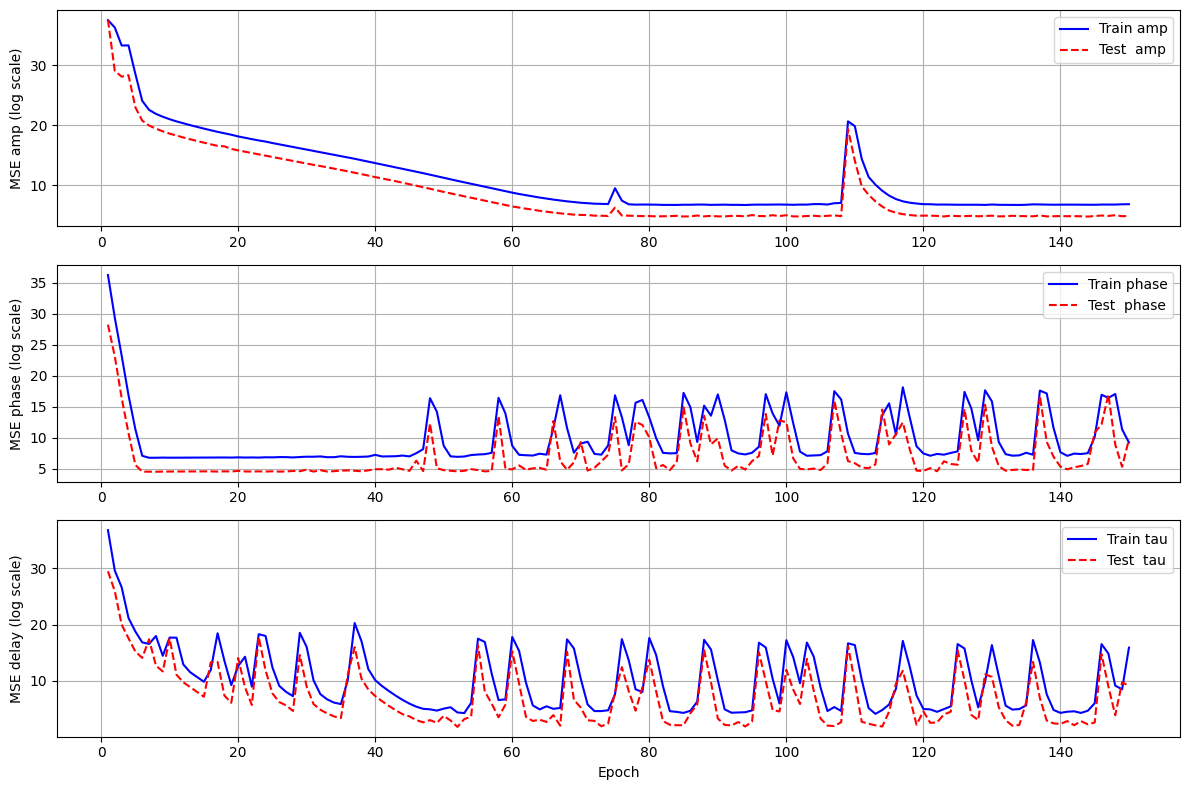

In [75]:
import matplotlib.pyplot as plt
epochs = range(1, len(trn_amp)+1)

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(epochs, np.log(trn_amp), 'b-', label="Train amp")
plt.plot(epochs, np.log(tst_amp), 'r--', label="Test  amp")
plt.ylabel("MSE amp (log scale)"); plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(epochs, np.log(trn_ph), 'b-', label="Train phase")
plt.plot(epochs, np.log(tst_ph), 'r--', label="Test  phase")
plt.ylabel("MSE phase (log scale)"); plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot(epochs, np.log(trn_tau),'b-', label="Train tau")
plt.plot(epochs, np.log(tst_tau),'r--', label="Test  tau")
plt.xlabel("Epoch"); 
plt.ylabel("MSE delay (log scale)"); 
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [62]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
        (amp_model1, phase_model1, tau_model1,
        train_loader, test_loader,
        trn_amp, trn_ph, trn_tau,
        tst_amp, tst_ph, tst_tau)= train(
        data_path_   = DATA_PATH,
        voxels_path  = "/root/channel_scatter_room/scene_voxels.npy",
        num_epochs   = 100,
        batch_size   = 10,
        max_paths    = 110,
        L            = 7,
        test_split   = 0.1,
        seed         = 123
    )

Dataset stats → total: 300, train: 270, test: 30
Epoch 001/100  Train → amp:3.5646e+16  phase:1.0925e+16  tau:1.9433e+16  Test → amp:8.3963e+13  phase:3.9551e+13  tau:9.3166e+13
Epoch 002/100  Train → amp:2.3457e+15  phase:7.2101e+13  tau:2.2400e+14  Test → amp:7.8106e+13  phase:2.6563e+12  tau:3.2531e+12
Epoch 003/100  Train → amp:5.1779e+14  phase:1.1632e+13  tau:8.7484e+13  Test → amp:1.1500e+14  phase:4.5237e+11  tau:4.7887e+12
Epoch 004/100  Train → amp:1.5849e+15  phase:1.8175e+12  tau:2.8008e+13  Test → amp:2.4004e+14  phase:1.2594e+11  tau:1.3067e+11
Epoch 005/100  Train → amp:6.5267e+14  phase:1.0043e+12  tau:3.5035e+11  Test → amp:1.6191e+13  phase:9.1897e+09  tau:6.6267e+09
Epoch 006/100  Train → amp:6.1511e+14  phase:3.5975e+10  tau:2.8546e+10  Test → amp:2.0439e+13  phase:8.0711e+08  tau:1.3497e+09
Epoch 007/100  Train → amp:5.7805e+13  phase:2.2296e+09  tau:8.0162e+09  Test → amp:1.6940e+12  phase:5.0629e+07  tau:5.6818e+08
Epoch 008/100  Train → amp:3.5086e+12  phase:1.3

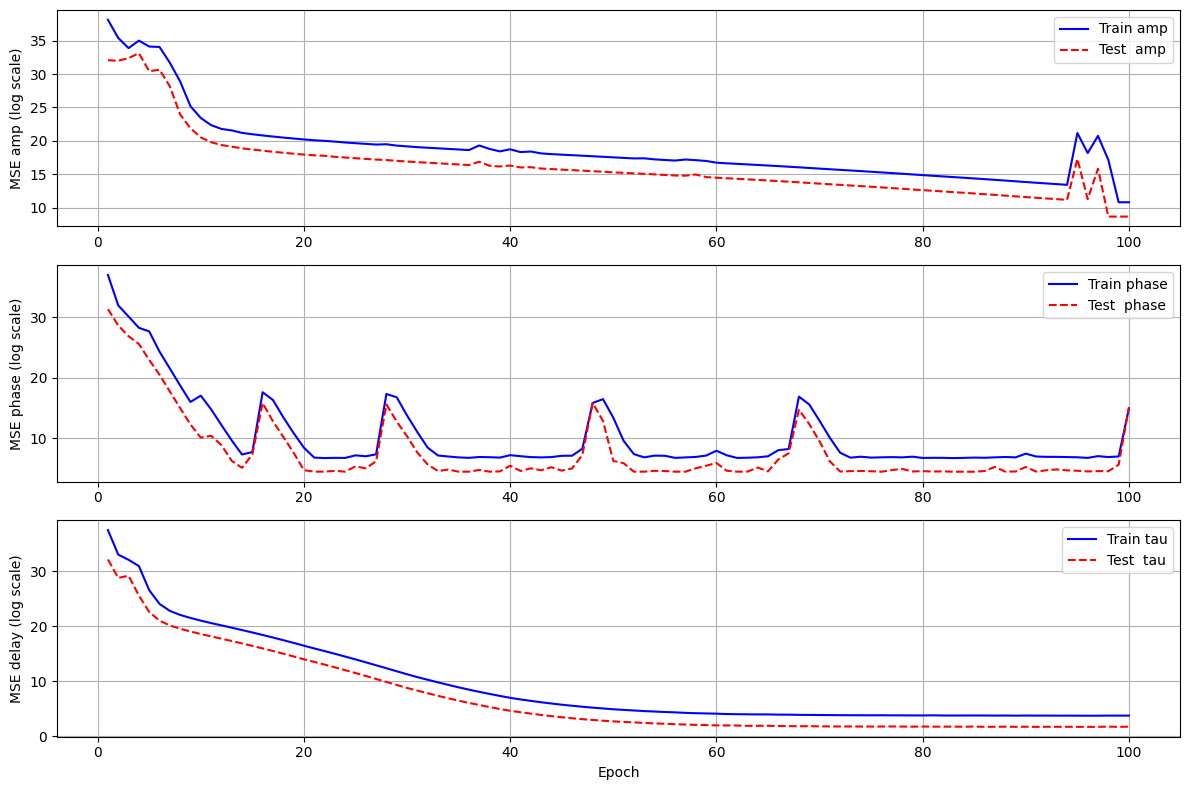

In [63]:
import matplotlib.pyplot as plt
epochs = range(1, len(trn_amp)+1)

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(epochs, np.log(trn_amp), 'b-', label="Train amp")
plt.plot(epochs, np.log(tst_amp), 'r--', label="Test  amp")
plt.ylabel("MSE amp (log scale)"); plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(epochs, np.log(trn_ph), 'b-', label="Train phase")
plt.plot(epochs, np.log(tst_ph), 'r--', label="Test  phase")
plt.ylabel("MSE phase (log scale)"); plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot(epochs, np.log(trn_tau),'b-', label="Train tau")
plt.plot(epochs, np.log(tst_tau),'r--', label="Test  tau")
plt.xlabel("Epoch"); 
plt.ylabel("MSE delay (log scale)"); 
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [67]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def evaluate_model(amp_model, phase_model, tau_model, loader,
                   device="cpu", n_plot=2):
    """
    Runs the three separate models on `loader` and returns average MSEs
    for log‐amp, phase and log‐delay.  Also plots up to n_plot examples
    of predictions vs ground‐truth for the first batch.
    """
    amp_model.to(device).eval()
    phase_model.to(device).eval()
    tau_model.to(device).eval()

    mse = F.mse_loss
    total_amp_loss   = 0.0
    total_phase_loss = 0.0
    total_tau_loss   = 0.0
    total_samples    = 0

    # grab one batch for plotting
    plot_batch = None

    with torch.no_grad():
        for batch in loader:
            pos     = batch["positions"].to(device)
            summary = batch["scene_summary"].to(device)
            log_amp = batch["log_amp"].to(device)       # (B,P)
            phase   = batch["phase"].to(device) 
            log_tau = batch["log_delay"].to(device)

            # forward
            amp_pred   = amp_model(pos, summary)       # (B,P)
            phase_pred = phase_model(pos, summary)     # (B,P)
            tau_pred   = tau_model(pos, summary)       # (B,P)

            B = pos.size(0)
            total_amp_loss   += mse(amp_pred,   log_amp,   reduction="sum").item()
            total_phase_loss += mse(phase_pred, phase,     reduction="sum").item()
            total_tau_loss   += mse(tau_pred,   log_tau,    reduction="sum").item()
            total_samples    += B

            if plot_batch is None:
                plot_batch = {
                    "log_amp":    log_amp.cpu().numpy(),
                    "phase":      phase.cpu().numpy(),
                    "log_tau":    log_tau.cpu().numpy(),
                    "amp_pred":   amp_pred.cpu().numpy(),
                    "phase_pred": phase_pred.cpu().numpy(),
                    "tau_pred":   tau_pred.cpu().numpy()
                }

    # compute averages
    avg_amp   = total_amp_loss   / total_samples
    avg_phase = total_phase_loss / total_samples
    avg_tau   = total_tau_loss   / total_samples

    print(f"Eval MSE → amp: {avg_amp:.6e}, phase: {avg_phase:.6e}, tau: {avg_tau:.6e}")

    # plotting
    if plot_batch and n_plot>0:
        B, P = plot_batch["log_amp"].shape
        examples = min(n_plot, B)
        x = range(P)
        for i in range(examples):
            fig, axs = plt.subplots(3,1, figsize=(10,12))
            # log‐amp
            axs[0].plot(x, plot_batch["log_amp"][i],    label="GT")
            axs[0].plot(x, plot_batch["amp_pred"][i],   label="Pred")
            axs[0].set_title("log‐amplitude"); axs[0].legend()
            # phase
            axs[1].plot(x, plot_batch["phase"][i],      label="GT")
            axs[1].plot(x, plot_batch["phase_pred"][i], label="Pred")
            axs[1].set_title("phase (scaled to ±1)"); axs[1].legend()
            # log‐tau
            axs[2].plot(x, plot_batch["log_tau"][i],    label="GT")
            axs[2].plot(x, plot_batch["tau_pred"][i],   label="Pred")
            axs[2].set_title("log‐delay"); axs[2].legend()
            plt.tight_layout()
            plt.show()

    return avg_amp, avg_phase, avg_tau

Eval MSE → amp: 5.052274e+02, phase: 1.381035e+07, tau: 2.054076e+01


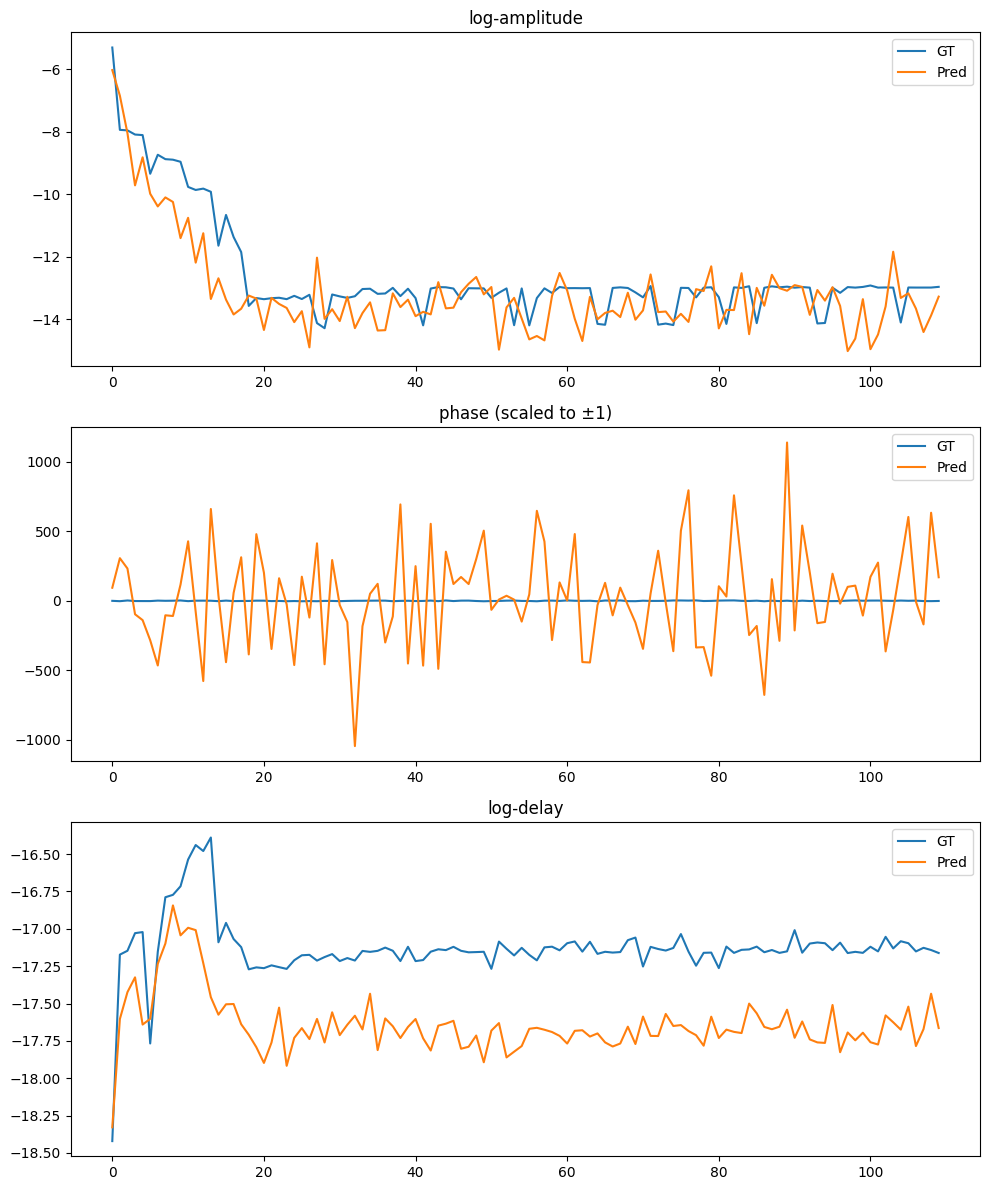

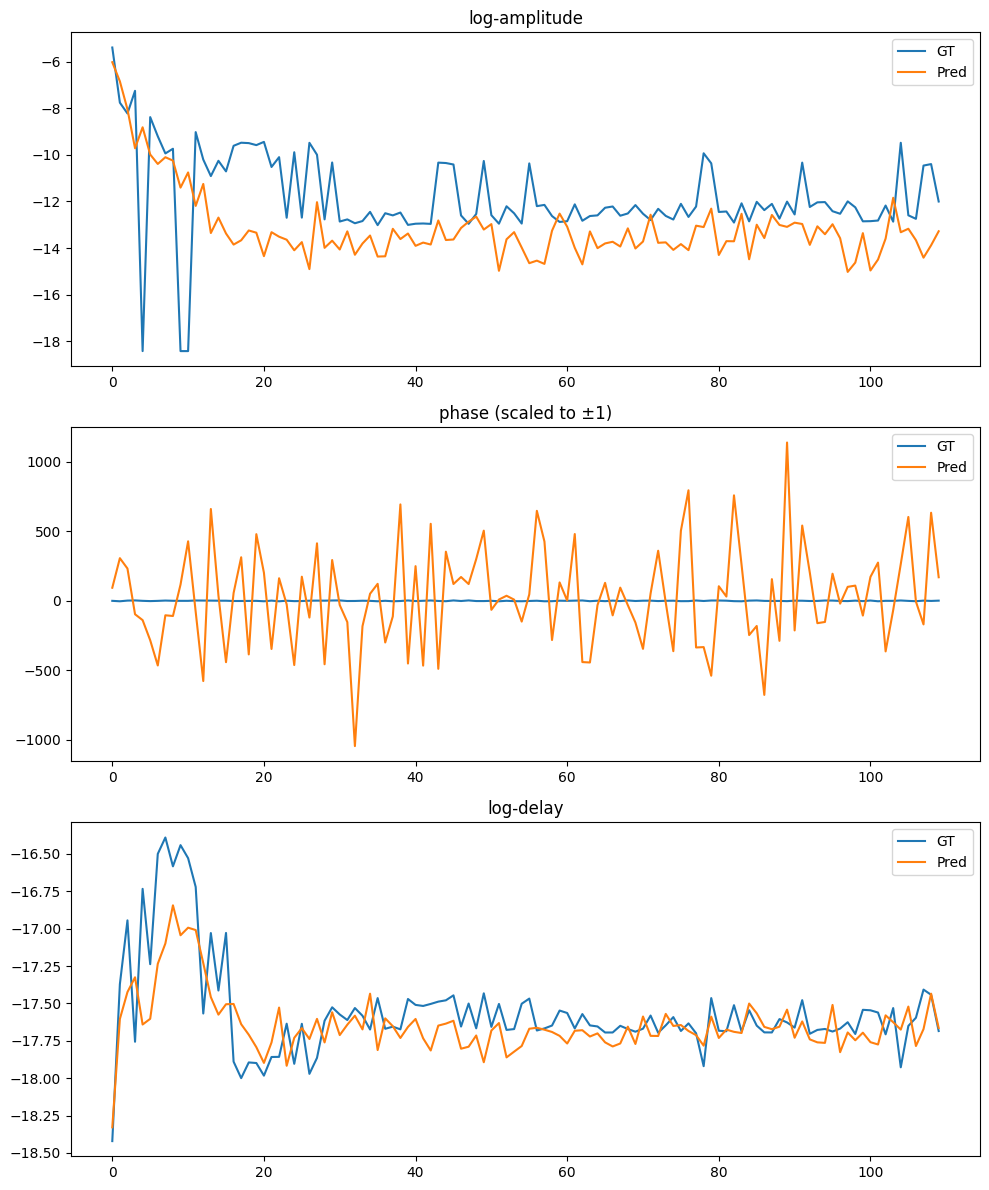

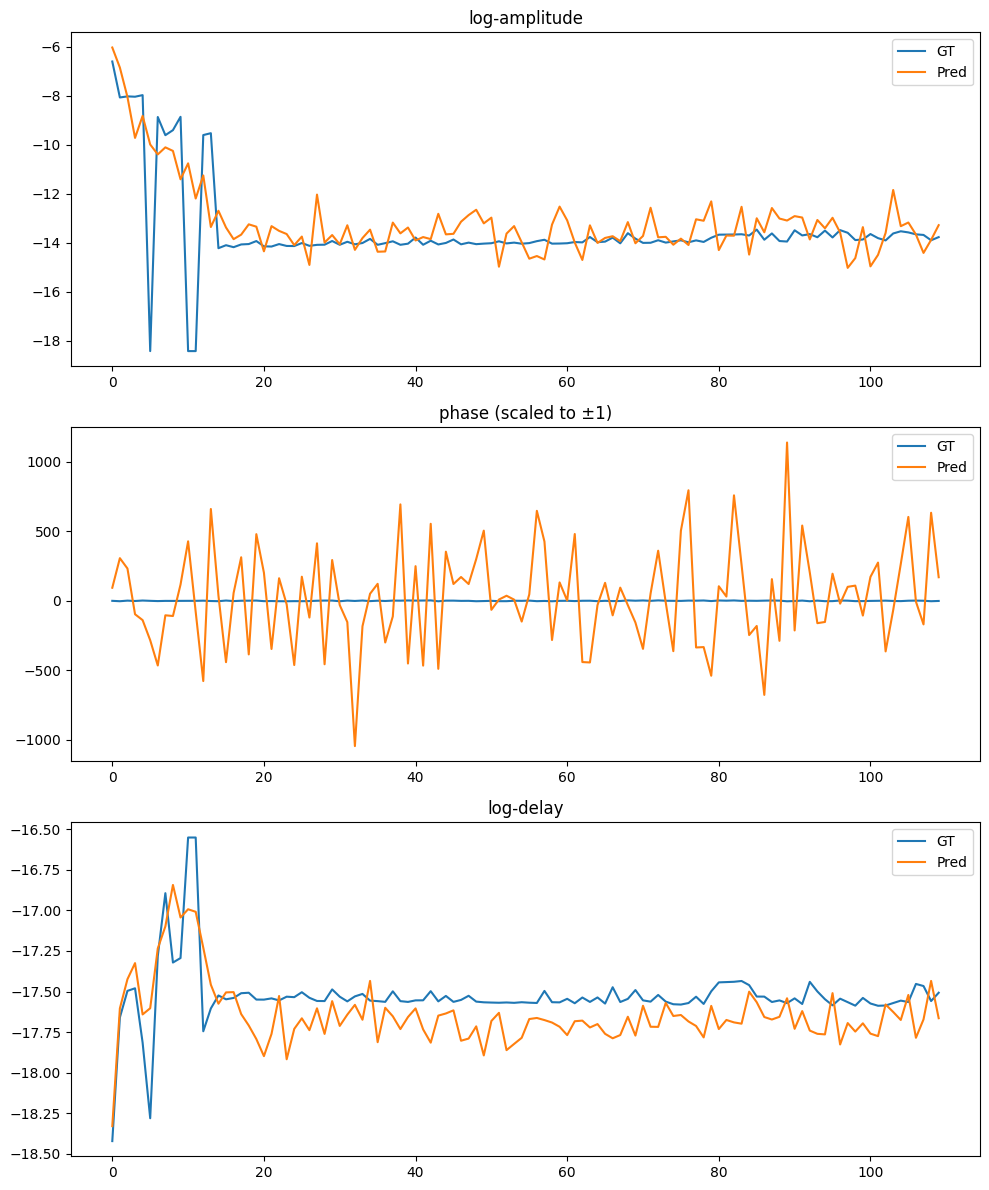

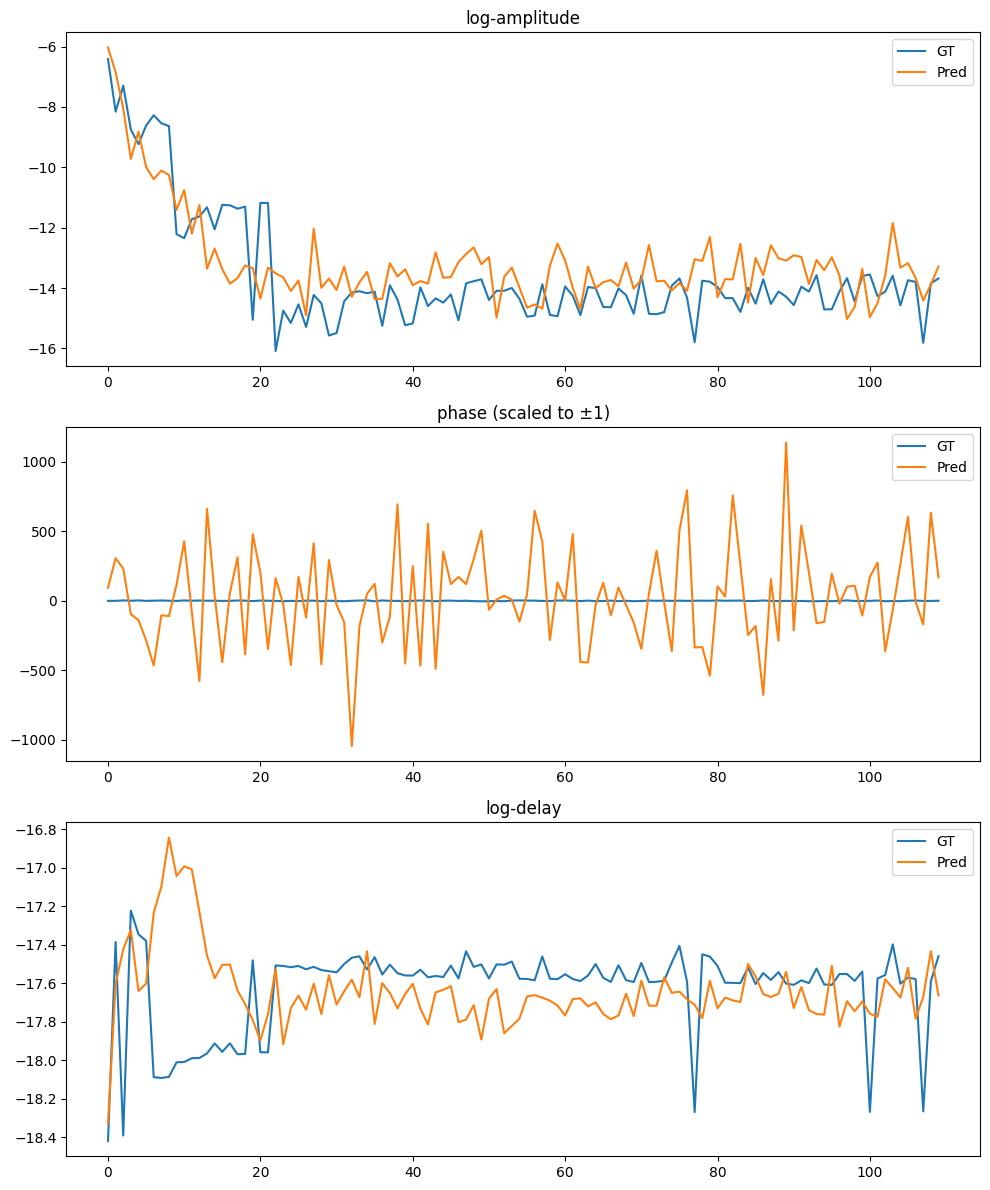

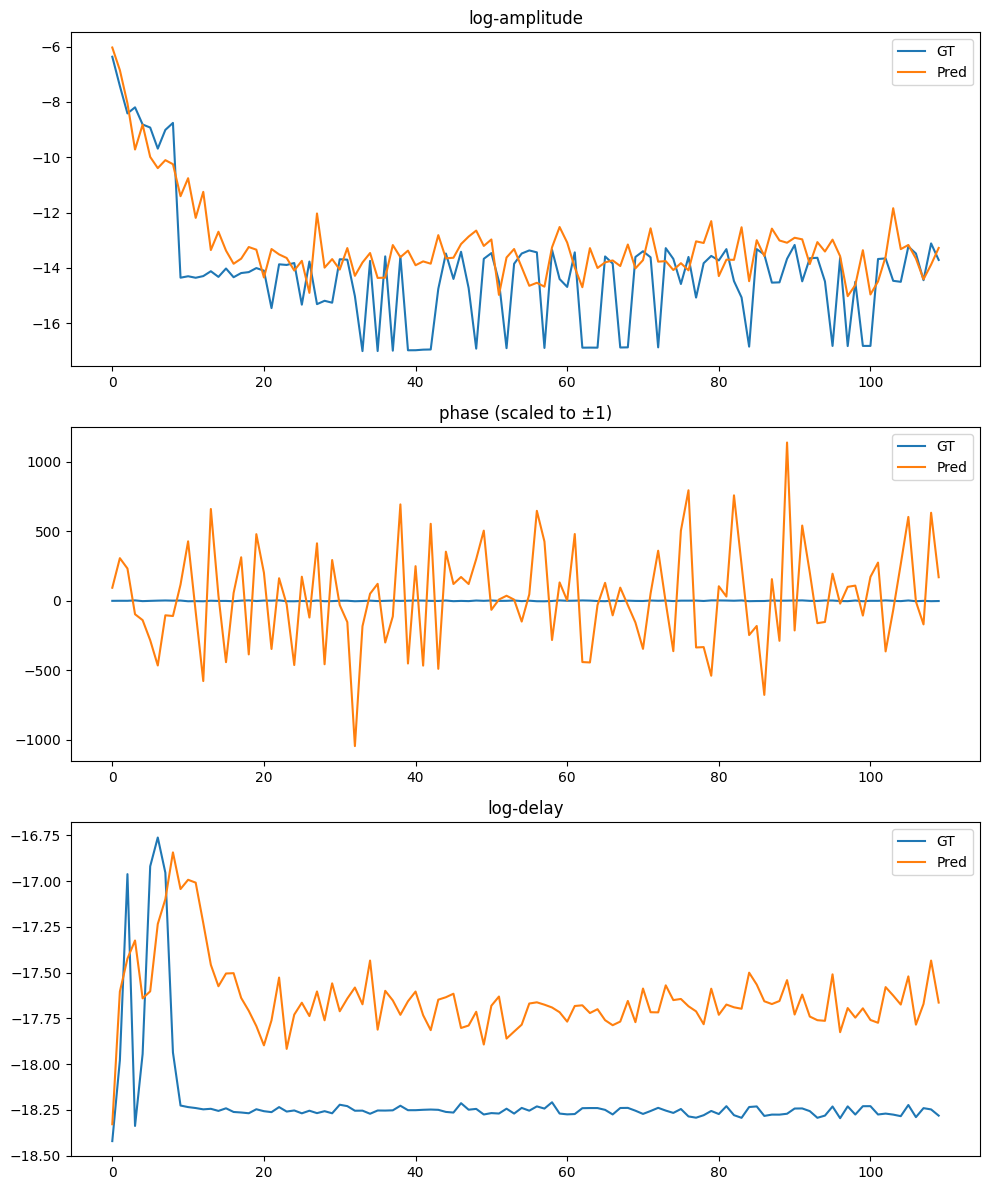

In [80]:
# after training is finished, or per‐epoch if you like
amp_m, phase_m, tau_m = evaluate_model(
    amp_model_main, phase_model1, tau_model1, test_loader,
    device=None, n_plot=10
)